# ViT OOD in PyTorch

In [1]:
device = 'cuda:0'

## dataset

In [2]:
from datasets import load_dataset

train_ds, test_ds = load_dataset('cifar10', split=['train', 'test[:2000]'])
splits = train_ds.train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']
cifar100_ds = load_dataset('cifar100', split='test[:2000]');

cifar10_train_ds = load_dataset('cifar10', split='train')

Found cached dataset cifar10 (/root/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4)


  0%|          | 0/2 [00:00<?, ?it/s]

Found cached dataset cifar100 (/root/.cache/huggingface/datasets/cifar100/cifar100/1.0.0/f365c8b725c23e8f0f8d725c3641234d9331cd2f62919d1381d1baa5b3ba3142)
Found cached dataset cifar10 (/root/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4)


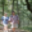

In [3]:
cifar100_ds[1]['img']

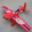

In [4]:
train_ds[0]['img']

In [5]:
id2label = {id:label for id, label in enumerate(train_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
id2label

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [6]:
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

In [7]:
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomResizedCrop, 
                                    Resize, 
                                    ToTensor)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
_train_transforms = Compose(
        [
            RandomResizedCrop(feature_extractor.size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(feature_extractor.size),
            CenterCrop(feature_extractor.size),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

In [8]:
# Set the transforms
train_ds.set_transform(train_transforms)

val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

In [9]:
cifar100_ds.set_transform(val_transforms)
cifar10_train_ds.set_transform(val_transforms)

In [10]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  num_labels=10,
                                                  id2label=id2label,
                                                  label2id=label2id)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
from transformers import TrainingArguments, Trainer

metric_name = "accuracy"
run_name = f"finetune-cifar-10-epoch1"

args = TrainingArguments(
    run_name,
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=1,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)

2022-10-19 05:58:12.103100: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
from datasets import load_metric
# import evaluate
import numpy as np

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

/tmp/ipykernel_14899/3889184740.py:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [13]:
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

def collate_fn_cifar100(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["fine_label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(test_ds, collate_fn=collate_fn, batch_size=4)
test_dataloader = DataLoader(test_ds, collate_fn=collate_fn, batch_size=4)
cifar100_dataloader = DataLoader(cifar100_ds, collate_fn=collate_fn_cifar100, batch_size=4)
cifar10_train_dataloader = DataLoader(cifar10_train_ds, collate_fn=collate_fn, batch_size=4)

In [14]:
import torch

trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
)

In [15]:
trainer.train()

/opt/conda/envs/evg/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 45000
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 3520
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: swyoon. Use `wandb login --relogin` to force relogin


/opt/conda/envs/evg/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.366340,0.976400
2,0.883500,0.210771,0.983400
3,0.379100,0.150856,0.985400
4,0.379100,0.119558,0.986400
5,0.293100,0.101623,0.986400
6,0.255700,0.087682,0.987400
7,0.255700,0.078763,0.988800
8,0.222900,0.074801,0.988000
9,0.208000,0.070454,0.989000
10,0.203800,0.069518,0.988600


***** Running Evaluation *****
  Num examples = 5000
  Batch size = 128
Saving model checkpoint to finetune-cifar-10/checkpoint-352
Configuration saved in finetune-cifar-10/checkpoint-352/config.json
Model weights saved in finetune-cifar-10/checkpoint-352/pytorch_model.bin
Feature extractor saved in finetune-cifar-10/checkpoint-352/preprocessor_config.json
/opt/conda/envs/evg/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 5000
  Batch size = 128
Saving model checkpoint to finetune-cifar-10/checkpoint-704
Configuration saved in finetune-cifar-10/checkpoint-704/config.json
Model weights saved in finetune-cifar-10/checkpoint-704/pytorch_model.bin
Feature extractor saved in finetune-cifar-10/checkpoint-704/preprocessor_config.json


TrainOutput(global_step=3520, training_loss=0.34858072061430323, metrics={'train_runtime': 2618.918, 'train_samples_per_second': 171.827, 'train_steps_per_second': 1.344, 'total_flos': 3.48738956568576e+19, 'train_loss': 0.34858072061430323, 'epoch': 10.0})

## Classification output

In [16]:
outputs = trainer.predict(test_ds)

***** Running Prediction *****
  Num examples = 2000
  Batch size = 128
/opt/conda/envs/evg/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


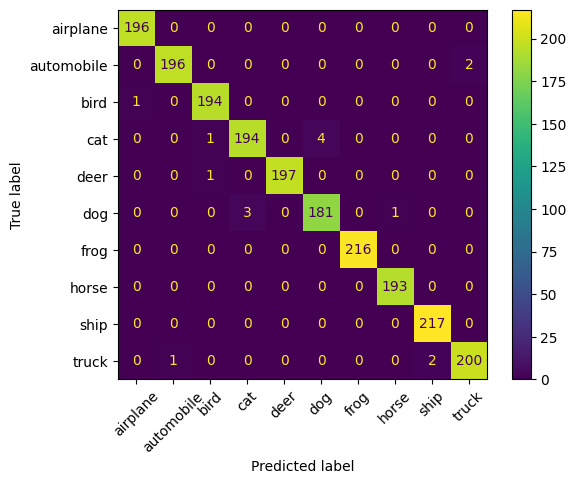

In [17]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = train_ds.features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

# Evaluate

In [18]:
from tqdm.notebook import tqdm

In [19]:
def get_logit(model, dl):
    l_pred = []
    for xx in tqdm(dl):
        with torch.no_grad():
            pred = model(xx['pixel_values'].cuda(), output_hidden_states=False)
            # pred.logits
            # pred.hidden_states
        l_pred.append(pred.logits.detach().cpu())
    return torch.cat(l_pred)

def get_prelogit(model, dl):
    l_pred = []
    for xx in tqdm(dl):
        with torch.no_grad():
            out = model(xx['pixel_values'].cuda(), output_hidden_states=True)
            out = out.hidden_states[-1][:,0,:]
            out = model.vit.layernorm(out)
        l_pred.append(out.detach().cpu())
    return torch.cat(l_pred)

In [20]:
cifar10_pred = get_logit(model, test_dataloader)
cifar100_pred = get_logit(model, cifar100_dataloader)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [21]:
cifar100_pred.shape, cifar10_pred.shape

(torch.Size([2000, 10]), torch.Size([2000, 10]))

In [22]:
from torch.nn.functional import softmax

In [23]:
cifar100_msp = torch.max(softmax(cifar100_pred, dim=1),dim=1).values
cifar10_msp = torch.max(softmax(cifar10_pred, dim=1),dim=1).values

In [24]:
cifar100_msp.shape

torch.Size([2000])

In [25]:
import sys
sys.path.append('../')
from utils import roc_btw_arr

In [26]:
roc_btw_arr(cifar10_msp, cifar100_msp)

0.9754998749999999

### Mahalanobis distance

In [27]:
prelogit = get_prelogit(model, cifar10_train_dataloader)

  0%|          | 0/12500 [00:00<?, ?it/s]

In [28]:
prelogit

tensor([[ 0.1410,  0.1106,  0.1008,  ...,  0.4057, -0.4537, -0.1590],
        [ 0.2571,  0.0024, -0.5031,  ..., -0.0038, -0.2854, -0.2425],
        [ 0.2478,  0.1938,  0.1852,  ...,  0.5305, -0.5101, -0.2045],
        ...,
        [-0.1525,  0.0196,  0.3926,  ..., -0.0524,  0.0545, -0.0774],
        [-0.0841,  0.1727,  0.1715,  ...,  0.0787, -0.0016, -0.4518],
        [-0.0591, -0.1459, -0.1257,  ..., -0.3283, -0.2571,  0.4618]])

In [29]:
cifar10_train_label = torch.tensor([cifar10_train_ds[i]['label'] for i in range(len(cifar10_train_ds))])

In [30]:
cifar10_train_label.shape

torch.Size([50000])

In [31]:
'''mahalanobis statistics computation'''
l_mean = []
l_outer = []
for k in range(10):
    subset_x = prelogit[cifar10_train_label == k]
    subset_mean = torch.mean(subset_x, dim=0, keepdim=True)
    # subset_outer = torch.cov(subset_x - subset_mean, correction=0) * len(subset_x)
    v = subset_x - subset_mean
    subset_outer = v.T.mm(v)
    l_mean.append(subset_mean)
    l_outer.append(subset_outer)
pooled_cov = torch.sum(torch.stack(l_outer), dim=0) / len(prelogit)
all_means = torch.stack(l_mean, dim=-1)
invcov = torch.linalg.inv(pooled_cov)

In [32]:
'''relative mahalanobis statistics'''
whole_mean = torch.mean(prelogit, dim=0, keepdim=True)
v = prelogit - whole_mean
whole_cov = v.T.mm(v) / len(prelogit)
whole_invcov = torch.linalg.inv(whole_cov)

In [42]:
'''save'''
torch.save({'all_means': all_means,
            'invcov': invcov,
            'whole_mean': whole_mean,
            'whole_invcov': whole_invcov}, f'{run_name}/maha-statistic.pkl')

In [33]:
pooled_cov

tensor([[ 3.2258e-03,  1.7853e-04,  5.1088e-05,  ...,  3.9735e-04,
         -5.2158e-04, -1.9311e-04],
        [ 1.7853e-04,  2.8777e-03,  8.5376e-06,  ...,  2.8643e-04,
         -1.0924e-04, -5.5726e-04],
        [ 5.1088e-05,  8.5376e-06,  3.9246e-03,  ..., -4.6748e-06,
         -1.2655e-04,  6.7128e-04],
        ...,
        [ 3.9735e-04,  2.8643e-04, -4.6748e-06,  ...,  3.4661e-03,
          1.3666e-04, -9.0770e-04],
        [-5.2158e-04, -1.0924e-04, -1.2655e-04,  ...,  1.3666e-04,
          3.2780e-03, -9.7789e-05],
        [-1.9311e-04, -5.5726e-04,  6.7128e-04,  ..., -9.0770e-04,
         -9.7789e-05,  4.9406e-03]])

In [34]:
pooled_cov[0,:10]

tensor([ 3.2258e-03,  1.7853e-04,  5.1088e-05, -1.7026e-04,  1.6226e-04,
        -6.7520e-04, -2.8712e-05, -3.9563e-04,  3.7475e-04,  2.5607e-06])

In [35]:
whole_cov[0,:10]

tensor([ 0.0670,  0.0111,  0.0054,  0.0064,  0.0286, -0.0268, -0.0178,  0.0030,
         0.0279, -0.0250])

In [36]:
def forward_maha(xx, mean, invcov):
    """
    mean: [1, D, K]
    invcov: [D, D]
    """
    z = xx.unsqueeze(-1) - mean
    op1 = torch.einsum('ijk,jl->ilk', z, invcov)
    op2 = torch.einsum('ijk,ijk->ik', op1, z)  # [B, K]
    
    return torch.min(op2, dim=1).values
    
def forward_maha_dl(model, dataloader, mean, invcov):
    l_score = []
    for xx in tqdm(dataloader):
        
        out = model(xx['pixel_values'].cuda(), output_hidden_states=True)
        out = out.hidden_states[-1][:,0,:]
        out = model.vit.layernorm(out)
        
        prelogit = out.detach().cpu()
        score = forward_maha(prelogit, mean, invcov)
        l_score.append(score)
    return torch.cat(l_score)
# forward_maha(subset_x, all_means, invcov)

cifar10_maha = forward_maha_dl(model, test_dataloader, all_means, invcov)
cifar100_maha = forward_maha_dl(model, cifar100_dataloader, all_means, invcov)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [37]:
roc_btw_arr(cifar100_maha, cifar10_maha)

0.98502225

In [38]:
def forward_rel_maha_dl(model, dataloader, mean, invcov, whole_mean, whole_invcov):
    l_score = []
    for xx in tqdm(dataloader):
        
        out = model(xx['pixel_values'].cuda(), output_hidden_states=True)
        out = out.hidden_states[-1][:,0,:]
        out = model.vit.layernorm(out)
        
        prelogit = out.detach().cpu()
        maha = forward_maha(prelogit, mean, invcov)
        rel_maha = forward_maha(prelogit, whole_mean, whole_invcov)
        l_score.append(maha - rel_maha)
    return torch.cat(l_score)

In [39]:
cifar10_rel_maha = forward_rel_maha_dl(model, test_dataloader, all_means, invcov, whole_mean.unsqueeze(-1), whole_invcov)
cifar100_rel_maha = forward_rel_maha_dl(model, cifar100_dataloader, all_means, invcov, whole_mean.unsqueeze(-1), whole_invcov)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [40]:
roc_btw_arr(cifar100_rel_maha, cifar10_rel_maha)

0.8989214999999999